<a href="https://colab.research.google.com/github/UthamanA/NYC-Taxi-trip-time-Prediction---capstone-project/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>




## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

So let's first mount the drive to load our dataset.

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Exploratory Data Analysis**

Now let's import all the important libraries that we'll be using for ou

In [39]:

# Importing the libraries
import numpy as np
import pandas as pd
from numpy import math
import xgboost
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import warnings
from pylab import rcParams
%matplotlib inline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
warnings.filterwarnings('ignore')

**After that let us fetch the data obviously.**

Working without data is like making a cake without bread.

In [40]:
# Importing the dataset
df = pd.read_csv('/content/drive/MyDrive/Capstone Project/cap pro 2 - Supervised ML - Regression/NYC Taxi Trip Time Prediction/NYC Taxi Data.csv')

Checking the shape so we get an idea of how many rows and features we have

In [41]:
df.shape

(1458644, 11)


That's quite alot i believe we will need to remove all the outliers and decrease the data as well.

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Some observations about the columns are :

**pickup_datetime** and **pickup_datetime** are in string format that are to be converted into datetime format.
**store_and_fwd_flag** is a categorical variable.

In [43]:
df.head()


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Typically in our world a taxi company always faces issues to provide best facilities to the customers.

Here we are presented with data which consists of alot of taxi trips. Now, here we will try to apply many techniques to understand and explore the data that is provided to us.

In [44]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


So from here we can see that:

Pasenger count varies from 0 to 9.
Trip duration has max value of 3526282 seconds almost 979.5 hours and minimum 1 second. This definetly has outliers present so we'll remove them.

After the basic analysis of our data we can see we have some outliers. Now let's chek if there isany null data.

In [45]:
df['trip_duration'].isnull().sum()

0

Thankfully there consists of no null data. Now moving forward let's remove all the duplicates present in the dataset.

In [46]:
df.drop_duplicates(inplace=True)
df.shape

(1458644, 11)


Now let's start analysing all the features(columns) one by one as Malcolm Bradbury has stated

Culture is a way of coping with the world by defining it in detail.

In [47]:
df['passenger_count'].value_counts().reset_index()

,index,passenger_count
0,1,1033540
1,2,210318
2,5,78088
3,3,59896
4,6,48333
5,4,28404
6,0,60
7,7,3
8,9,1
9,8,1


As we can see the number of passengers varies from 0 to 9.

In [48]:
df[df['passenger_count']==0].count()

id                    60
vendor_id             60
pickup_datetime       60
dropoff_datetime      60
passenger_count       60
pickup_longitude      60
pickup_latitude       60
dropoff_longitude     60
dropoff_latitude      60
store_and_fwd_flag    60
trip_duration         60
dtype: int64


Dropping all the data with zero passengers in it as we can't really say anything about the taxi which already has no passenger in it.

In [49]:
df=df[df['passenger_count']!=0]

Now let's get back to our date time data and handle it

In [50]:
df["pickup_datetime"][0]

'2016-03-14 17:24:55'

Converting it from the string format to date time format and saving it in the row itself

In [51]:
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'])
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


As we all know graphs are like a backbone of any data analyst and without them it is very difficult for normal people to figure out what we have done in our Data Analysis so let's start plotting some graphs. As it was rightly

Now as we know that our target variable which is trip_duration have some outliers as well now let's plot it's graph.

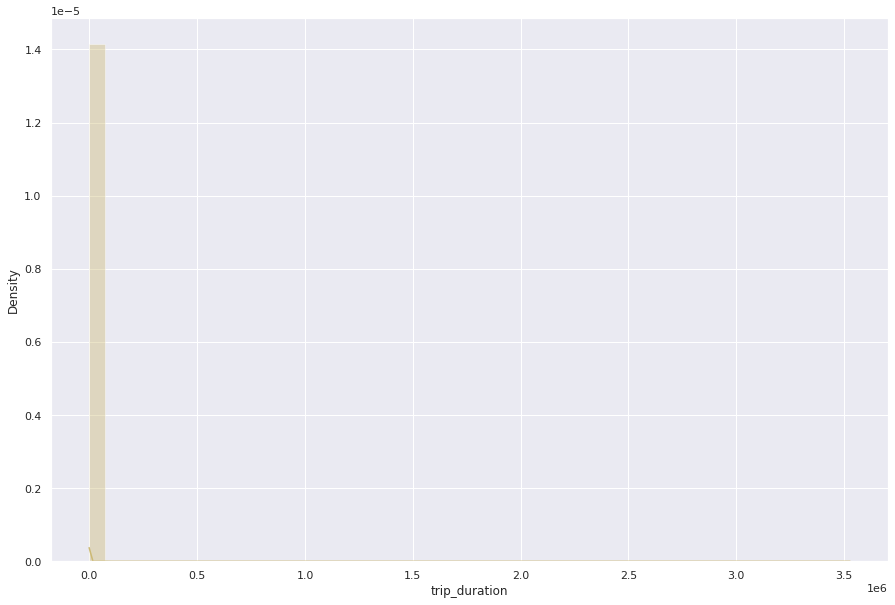

In [52]:
# Dependent variable 'trip_duration'
plt.figure(figsize=(15,10))
sns.distplot(df['trip_duration'],color="y")

So we can see there is some skweness in our data. Trip duration is left skewed so handling it by using log transformation to normalize the data.

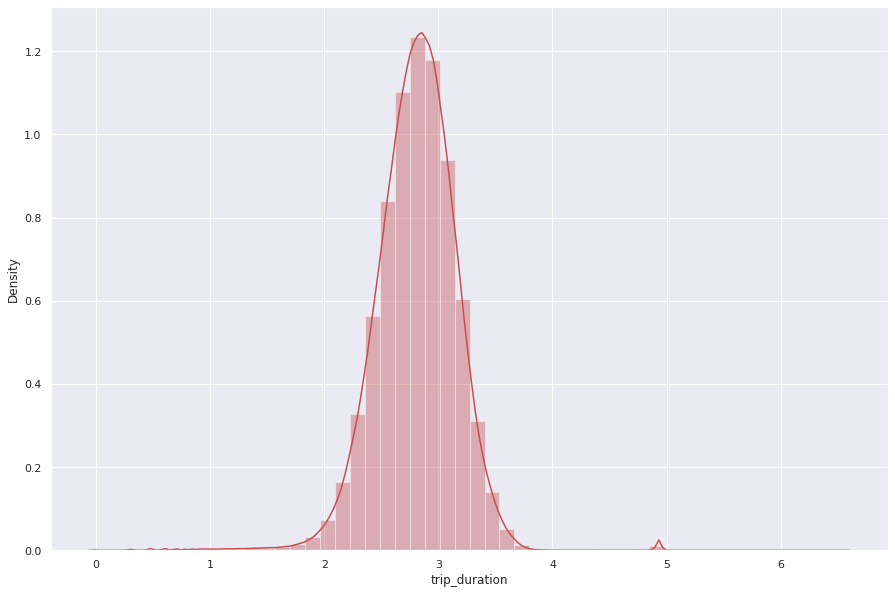

In [53]:
plt.figure(figsize=(15,10))
sns.distplot(np.log10(df['trip_duration']),color="R")


Now let's have a look at our numerical features and make a box plot to see how many outliers do they contain

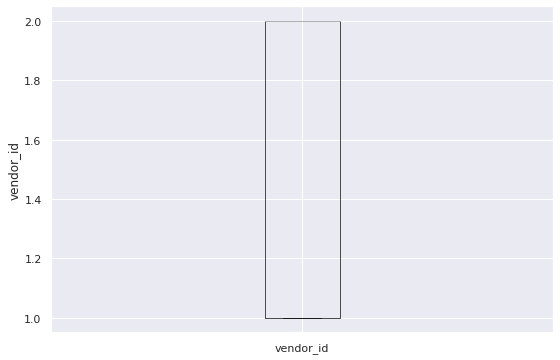

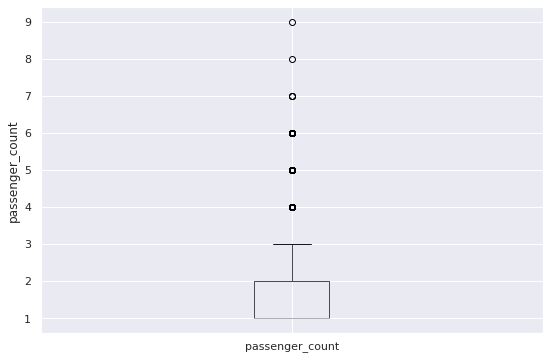

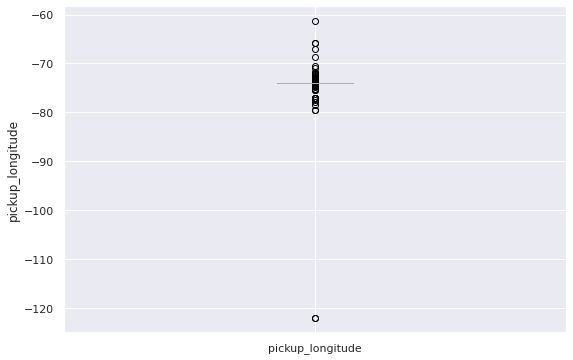

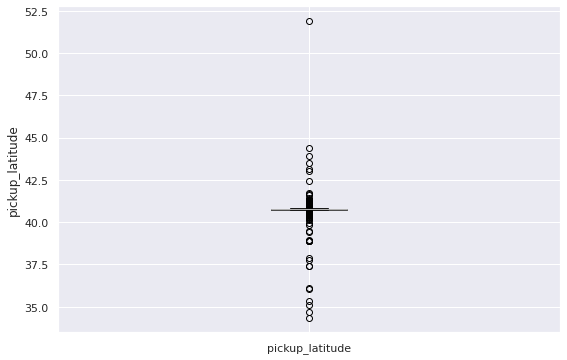

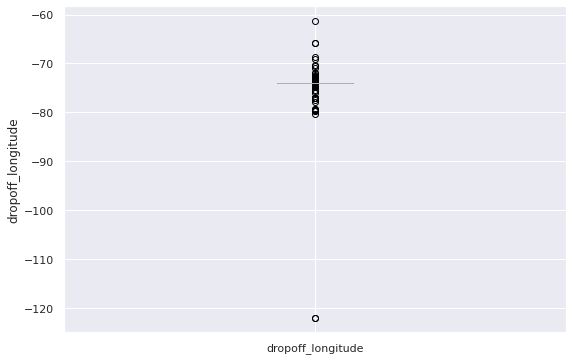

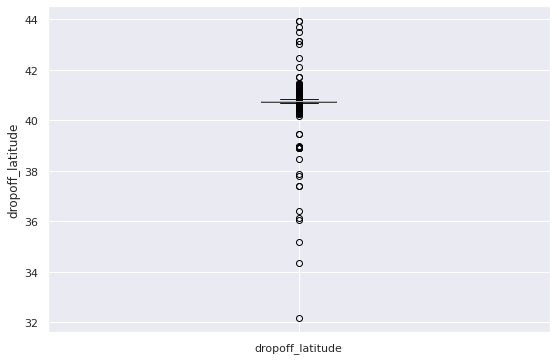

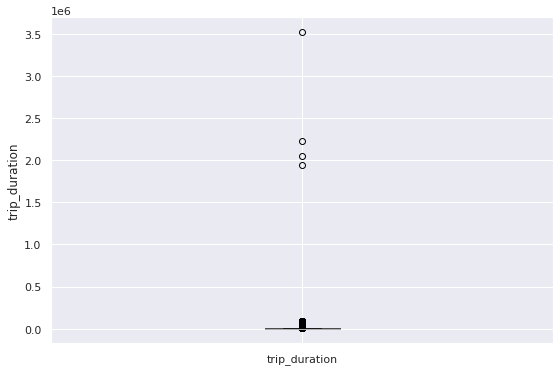

In [54]:
# plot a boxplot for the label by each numerical feature  
for col in df.describe().columns:
  fig = plt.figure(figsize=(9, 6))
  ax = fig.gca()
  df.boxplot(column = col, ax = ax)
  ax.set_ylabel(col)
plt.show()

Okay so what we know now :

Vendor ID has no outlier.

In passenger count 4 and more passengers are being treated as outliers.

pickup_longitude and pickup_latitude has outliers as well.

dropoff_longitude and dropoff_latitude has outliers too.

Our target variable trip_duration has alot of outliers

Now it's time for our white blood cells to get in action and remove these outliers. So our Outlier treatment will be using **IQR(inter-quartile range)** method

In [55]:
numeric_features = df.describe().columns
numeric_features

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration'],
      dtype='object')

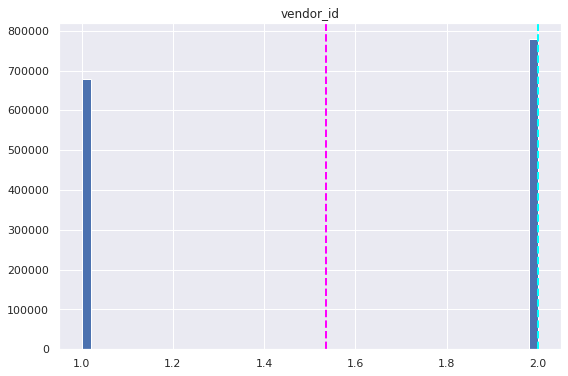

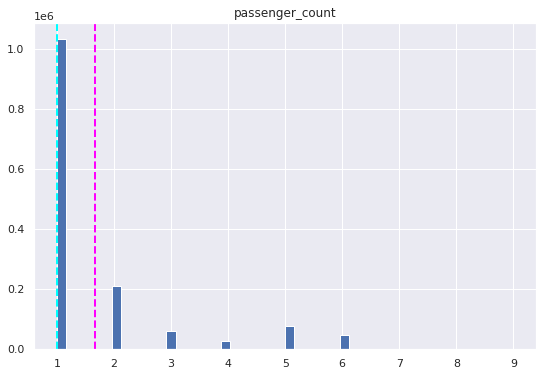

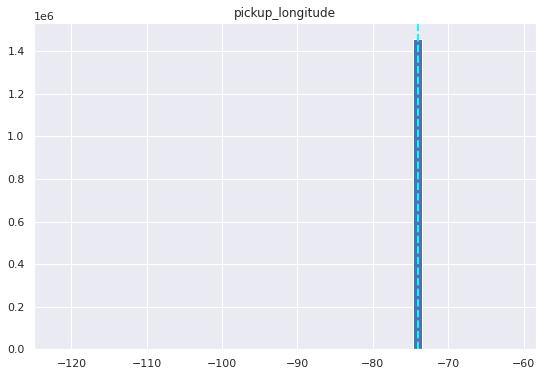

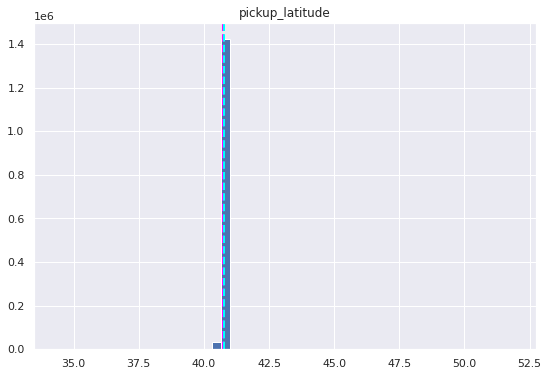

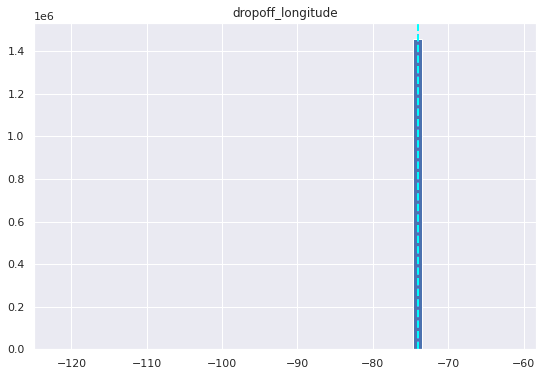

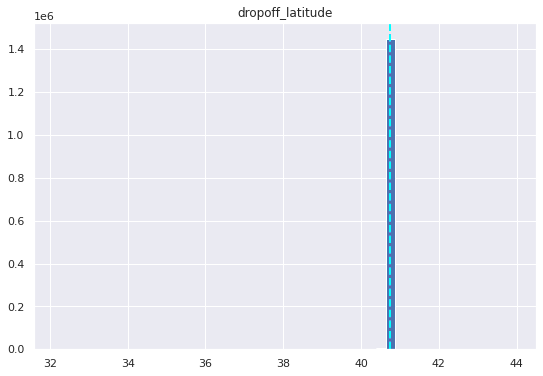

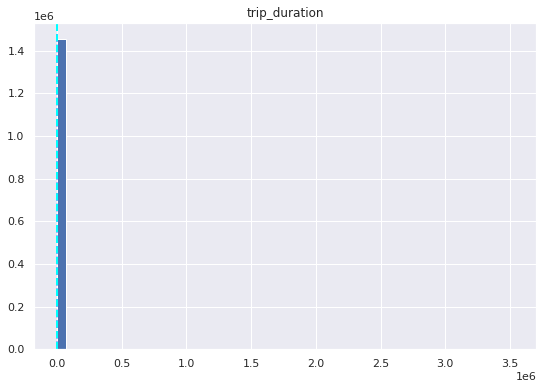

In [56]:
# plot a bar plot for each numerical feature count
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    feature.hist(bins=50, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
    ax.set_title(col)
plt.show()


Let us aslo plot a scatter plot as well to get more understanding of our feature

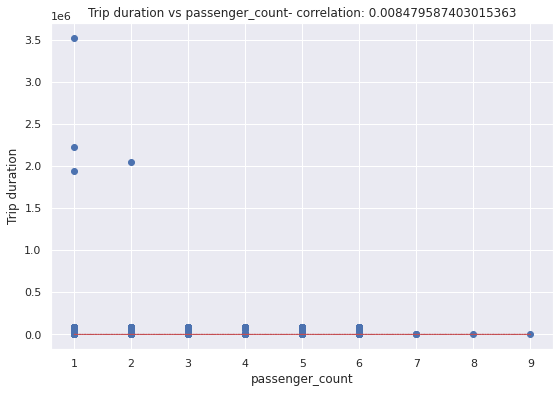

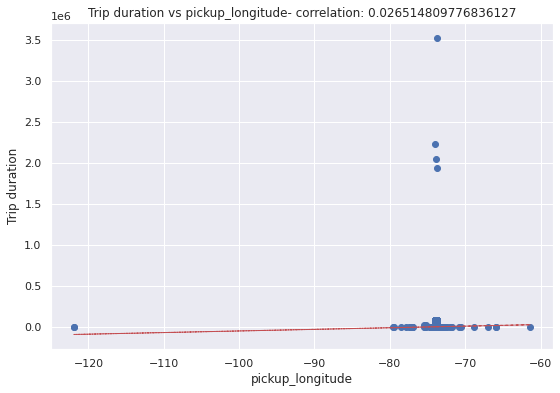

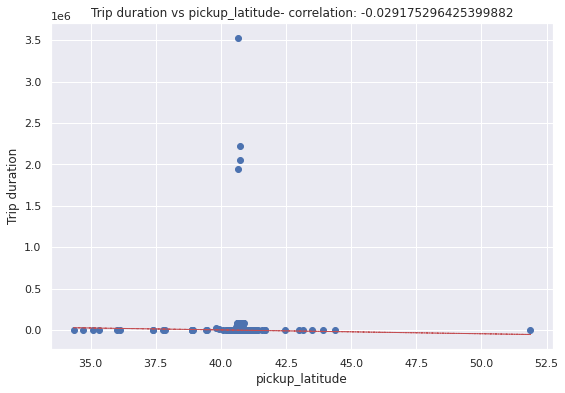

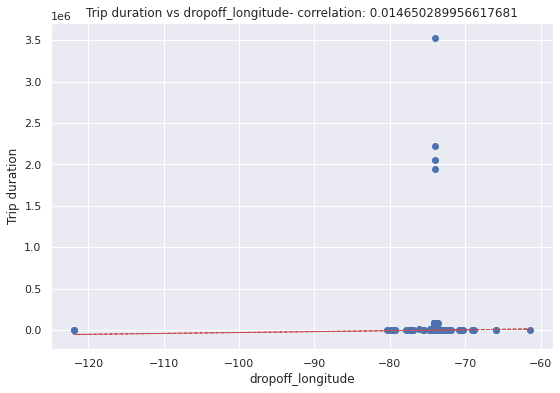

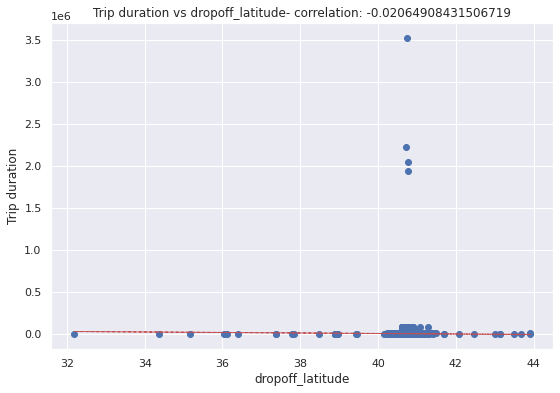

In [57]:
for col in numeric_features[1:-1]:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    label = df['trip_duration']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Trip duration')
    ax.set_title('Trip duration vs ' + col + '- correlation: ' + str(correlation))
    z = np.polyfit(df[col], df['trip_duration'], 1)
    y_hat = np.poly1d(z)(df[col])

    plt.plot(df[col], y_hat, "r--", lw=1)

plt.show()

We were working on a dataset with taxi don't forget that we all kow sometimes when we start thinking too deply we tend to forget what we were doing so let's work with latitude and longitude which we have.

**Here we will plot a scatter plot of pickup and dropoff locations.**

Text(0.5, 1.0, 'Dropoff')

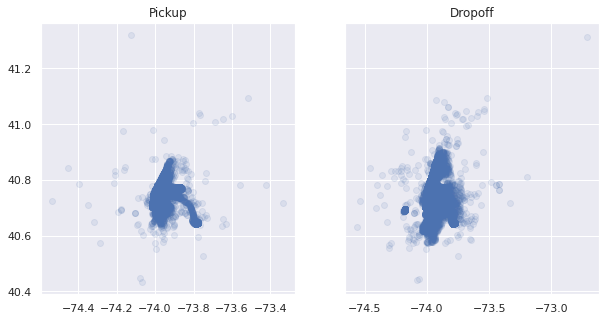

In [58]:
#plot to see the differences - minimal, but there is some change
n = 100000 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.scatter(df.pickup_longitude[:n], 
            df.pickup_latitude[:n],
            alpha = 0.1)
ax1.set_title('Pickup')
ax2.scatter(df.dropoff_longitude[:n], 
            df.dropoff_latitude[:n],
            alpha = 0.1)
ax2.set_title('Dropoff')


Let us try to atleast see what places were booked the most using our political and geographical maps. We know everyone loves maps so let's



In [59]:
def select_within_boundingbox(df, BB):
    return ((df["pickup_longitude"] >= BB[0]) & (df["pickup_longitude"] <= BB[1]) & 
            (df["pickup_latitude"] >= BB[2]) & (df["pickup_latitude"] <= BB[3]) &
            (df["dropoff_longitude"] >= BB[0]) & (df["dropoff_longitude"] <= BB[1]) &
            (df["dropoff_latitude"] >= BB[2]) & (df["dropoff_latitude"] <= BB[3]))
BB = (-74.3, -73.0, 40.6, 41.7)

In [60]:
nyc_map1 = plt.imread('/content/drive/MyDrive/Capstone Project/cap pro 2 - Supervised ML - Regression/NYC Taxi Trip Time Prediction/NYC.webp')
nyc_map2 = plt.imread('/content/drive/MyDrive/Capstone Project/cap pro 2 - Supervised ML - Regression/NYC Taxi Trip Time Prediction/NYC.jpg')

In [61]:
df = df[select_within_boundingbox(df, BB)]
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1,2,figsize=(13, 8))
    axs[0].scatter(df["pickup_longitude"], df["pickup_latitude"], alpha = alpha, c='g', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup Locations')
    axs[0].imshow(nyc_map, extent=BB)
    
    axs[1].scatter(df["dropoff_longitude"], df["dropoff_latitude"] , alpha = alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff Locations')
    axs[1].imshow(nyc_map, extent=BB)

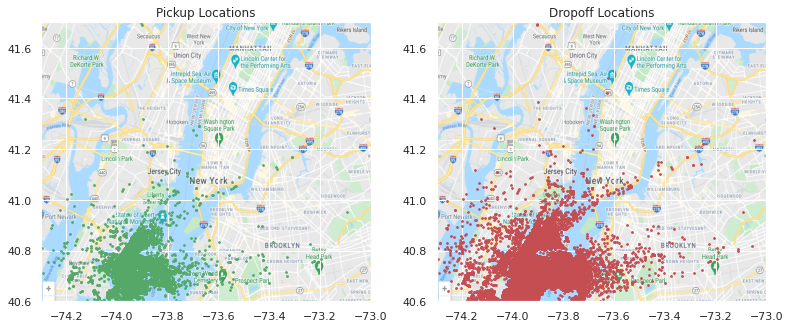

In [62]:

plot_on_map(df, BB, nyc_map1, s=3, alpha=1)

Plotting the pickup and drop off locations on political map (zoomed out)


In [63]:
import folium
f = folium.Figure(width=1500, height=500)
mapa = folium.Map(location = (40.7679, -73.9822), zoom_start=11).add_to(f)

for index, row in df.sample(1000).iterrows():
    folium.Marker([row["pickup_latitude"], row["pickup_longitude"]], icon=folium.Icon(color="blue")).add_to(mapa)
    folium.Marker([row["dropoff_latitude"], row["dropoff_longitude"]], icon=folium.Icon(color="red")).add_to(mapa)
display(mapa)

So now let's do some feature engineering as we know what EDA have we even done unless we don't do some feature engineering.

#**Feature Engineering**

As we have converted our date time column into manipulative form now let's make use of it to explore the data and let it help the model run better.

We will make new columns for days of the week of their corresponging pickup and drop-off day

In [64]:
df['pickup_day']=df['pickup_datetime'].dt.day_name()
df['dropoff_day']=df['dropoff_datetime'].dt.day_name()
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,dropoff_day
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday



After this we will now let's try to visualise our data and see which day has been the busiest for our hard working taxi drivers

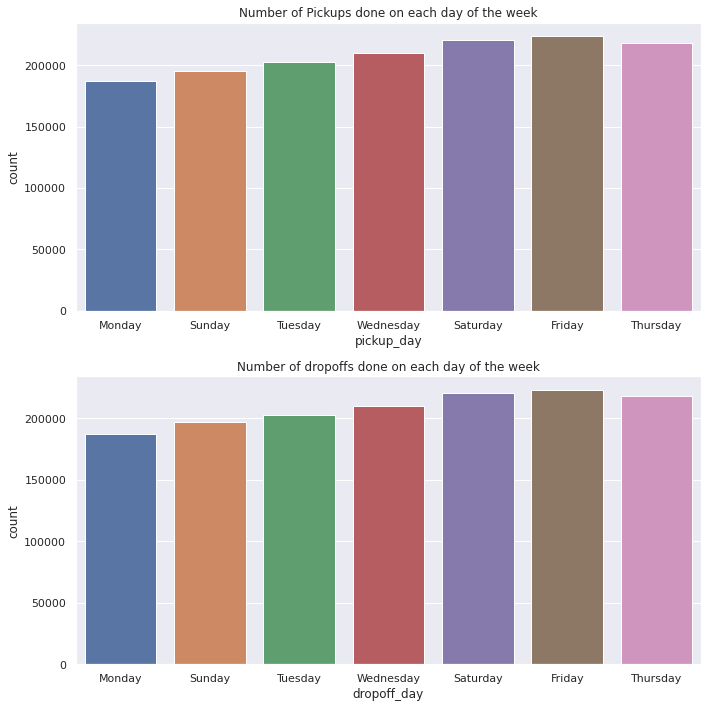

In [65]:
figure,ax=plt.subplots(nrows=2,ncols=1,figsize=(10,10))
sns.countplot(x='pickup_day',data=df,ax=ax[0])
ax[0].set_title('Number of Pickups done on each day of the week')
sns.countplot(x='dropoff_day',data=df,ax=ax[1])
ax[1].set_title('Number of dropoffs done on each day of the week')
plt.tight_layout()

**Thus we see most trips were taken on Friday and Monday being the least. The distribution of trip duration with the days of the week is something to look into as well.**

Well it actually makes sense because most people will want to go out and enjoy their weekends partying and noone will have time to do that on a Monday. As everyone needs to earn the money back which was spent on Friday while parying.

Okay so as we have our days now let's also try to figure out the time and see what time was the busiest and what is least busiest.

**The distribution of Pickup and Drop Off hours of the day**

The time part is represented by hours,minutes and seconds which is difficult for the analysis thus we divide the times into 4 time zones:

**Morning** (4 hrs to 10 hrs)

**Midday** (10 hrs to 16 hrs)

**Evening** (16 hrs to 22 hrs)

**Late night** (22 hrs to 4 hrs)

In [66]:
bins=np.array([0,1800,3600,5400,7200,90000])
df['duration_time']=pd.cut(df.trip_duration,bins,labels=["< 5", "5-10", "10-15","15-20",">20"])

In [67]:
import datetime
def timezone(x):
    if x>=datetime.time(4, 0, 1) and x <=datetime.time(10, 0, 0):
        return 'morning'
    elif x>=datetime.time(10, 0, 1) and x <=datetime.time(16, 0, 0):
        return 'midday'
    elif x>=datetime.time(16, 0, 1) and x <=datetime.time(22, 0, 0):
        return 'evening'
    elif x>=datetime.time(22, 0, 1) or x <=datetime.time(4, 0, 0):
        return 'late night'
    
df['pickup_timezone']=df['pickup_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )
df['dropoff_timezone']=df['dropoff_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )

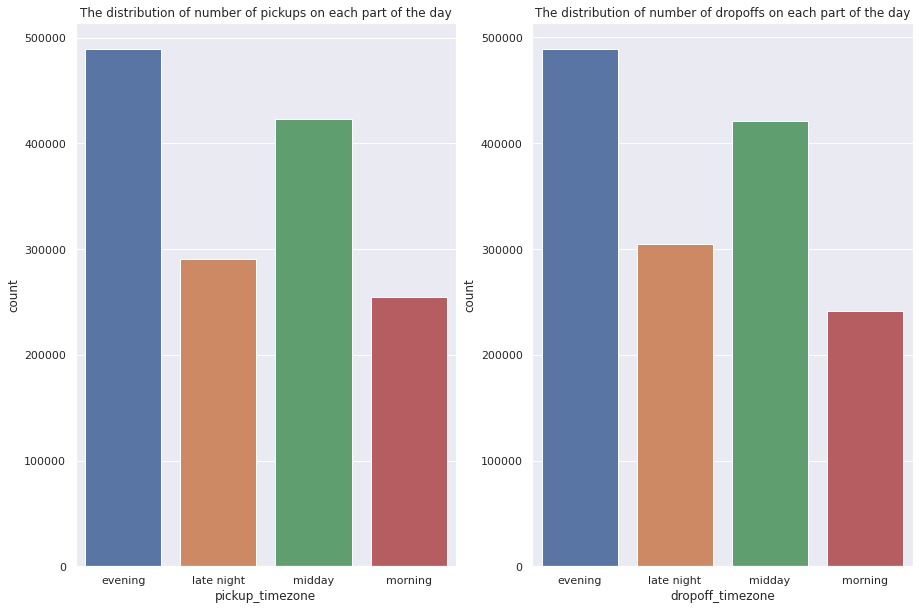

In [68]:
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,10))
sns.countplot(x='pickup_timezone',data=df,ax=ax[0])
ax[0].set_title('The distribution of number of pickups on each part of the day')
sns.countplot(x='dropoff_timezone',data=df,ax=ax[1])
ax[1].set_title('The distribution of number of dropoffs on each part of the day')
plt.show()

So now we can see that our taxi's were booked in the evening most and midday following it while very less people travel in the morning as compared.

Text(0.5, 1.0, 'The Distribution of percentage of different duration of trips')

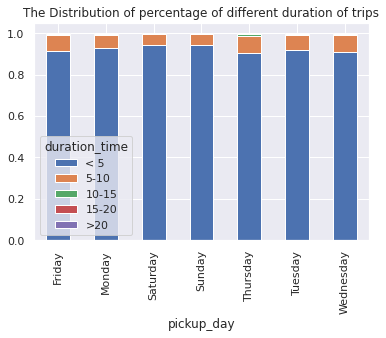

In [69]:
ax1=df.groupby('pickup_day')['duration_time'].value_counts(normalize=True).unstack()
ax1.plot(kind='bar', stacked='True')
plt.title('The Distribution of percentage of different duration of trips')

Now we have worked enough on the time zones and days of the week now let's start working with a new varibale. So we know we have a longitude and latitude present so we will work on it to make a new feature that is distance.

**So making a new distance column from the latitude and longitude**

In [70]:
from math import sin, cos, sqrt, atan2, radians

def get_distance(lon_1, lon_2, lat_1, lat_2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat_1)
    lon1 = radians(lon_1)
    lat2 = radians(lat_2)
    lon2 = radians(lon_2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

In [71]:
df["distance"] = df.apply(lambda x: get_distance(x["pickup_longitude"],x["dropoff_longitude"],x["pickup_latitude"],x["dropoff_latitude"]),axis=1)